### VQ-VAE

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F 
import matplotlib.pyplot as plt
from util import ikdpp,torch2np,np2torch
%matplotlib inline
%config InlineBackend.figure_format='retina'
print ("Torch version:[%s]"%(torch.__version__))

Torch version:[1.12.0.dev20220519]


### Vector Quantizer

In [2]:
class VectorQuantizerClass(nn.Module):
    """
        Vector Quantizer
    """
    def __init__(self,name='VQ',K=20,e_dim=2,beta=0.1,e_min=-1/2,e_max=+1/2,device='cpu'):
        """
            Initialize VQ
        """
        super(VectorQuantizerClass,self).__init__()
        self.name   = name
        self.K      = K
        self.e_dim  = e_dim
        self.beta   = beta   # commitment loss coef
        self.e_min  = e_min  # default is 1/K
        self.e_max  = e_max
        self.device = device
        # Initialize codebook
        self.init_codebook(e_min=self.e_min,e_max=self.e_max)
        self.to(self.device)
        
    def init_codebook(self,e_min,e_max):
        """
            Initialize codebook
        """
        self.codebook = nn.Embedding(num_embeddings=self.K,embedding_dim=self.e_dim)
        # Initilize codes
        self.codebook.weight.data.uniform_(e_min,e_max)
        
    def get_codebook(self):
        """
            Get codes of the codebook
        """
        return self.codebook.weight
    
    def compute_loss(self,z_code,z_e):
        """
            Compute the loss
            - z_code : codes in the codebook [B x e_dim]
            - z_e    : output of the encoder [B x e_dim] 
        """
        vq_loss    = torch.mean((z_code.detach()-z_e)**2)
        com_loss   = torch.mean((z_code-z_e.detach())**2) # commitment loss -> change the codebook
        total_loss = vq_loss + self.beta*com_loss
        return total_loss
    
    def forward(self,z_e):
        """
            Forward 
            - z_e: [B x e_dim]
        """
        # Distances from z to embeddings (z - e)^2 = z^2 + e^2 - 2 e * z
        d = torch.sum(z_e**2,dim=1,keepdim=True) + \
            torch.sum(self.codebook.weight**2,dim=1,keepdim=True).t() - \
            2*torch.matmul(z_e,self.codebook.weight.t())
        # Compute minimum distance indices (per batch) and corresponding codes 'z_q'
        min_idxs = torch.argmin(d,dim=1)
        z_code = self.codebook(min_idxs).view(z_e.shape) # [B x e_dim]
        # Compute loss
        loss = self.compute_loss(z_code,z_e)
        return z_code,loss
    
print ("Done.")        

Done.


### VQ-VAE

In [3]:
class VQVAE_Class(nn.Module):
    """
        VQ-VAE
    """
    def __init__(self,
                 name     = 'VQVAE',
                 x_dim    = 784,
                 z_dim    = 2,
                 K        = 10, # size of codebook
                 h_dims   = [64,32],
                 beta     = 0.25,
                 e_min    = -1.0,
                 e_max    = +1.0,
                 actv_enc = nn.LeakyReLU(),
                 actv_dec = nn.LeakyReLU(),
                 actv_out = None,
                 device   = 'cpu'):
        """
            Initialize VQ-VAE
        """
        super(VQVAE_Class,self).__init__()
        self.name     = name
        self.x_dim    = x_dim
        self.z_dim    = z_dim
        self.K        = K
        self.h_dims   = h_dims
        self.beta     = beta
        self.e_min    = e_min
        self.e_max    = e_max
        self.actv_enc = actv_enc
        self.actv_dec = actv_dec
        self.actv_out = actv_out
        self.device   = device
        # Initialize layers
        self.init_layers()
        self.init_params()
        # Vector quantization
        self.VQ = VectorQuantizerClass(K=K,e_dim=self.z_dim,beta=self.beta,e_min=self.e_min,e_max=self.e_max,device=self.device)
      
    def init_layers(self):
        """
            Initialize layers
        """
        self.layers = {}
        # Encoder part
        h_dim_prev = self.x_dim
        for h_idx,h_dim in enumerate(self.h_dims):
            self.layers['enc_%02d_lin'%(h_idx)]  = nn.Linear(h_dim_prev,h_dim,bias=True)
            self.layers['enc_%02d_actv'%(h_idx)] = self.actv_enc
            h_dim_prev = h_dim
        self.layers['ze_lin']  = nn.Linear(h_dim_prev,self.z_dim,bias=True)
        # Decoder part
        h_dim_prev = self.z_dim
        for h_idx,h_dim in enumerate(self.h_dims[::-1]):
            self.layers['dec_%02d_lin'%(h_idx)]  = nn.Linear(h_dim_prev,h_dim,bias=True)
            self.layers['dec_%02d_actv'%(h_idx)] = self.actv_dec
            h_dim_prev = h_dim
        self.layers['out_lin'] = nn.Linear(h_dim_prev,self.x_dim,bias=True)
        # Append parameters
        self.param_dict = {}
        for key in self.layers.keys():
            layer = self.layers[key]
            if isinstance(layer,nn.Linear):
                self.param_dict[key+'_w'] = layer.weight
                self.param_dict[key+'_b'] = layer.bias
        self.vae_parameters = nn.ParameterDict(self.param_dict)
        self.to(self.device)
        
    def init_params(self):
        """
            Initialize parameters
        """
        for key in self.layers.keys():
            layer = self.layers[key]
            if isinstance(layer,nn.Linear):
                nn.init.normal_(layer.weight,mean=0.0,std=0.1)
                nn.init.zeros_(layer.bias)
            elif isinstance(layer,nn.BatchNorm2d):
                nn.init.constant_(layer.weight,1.0)
                nn.init.constant_(layer.bias,0.0)
            elif isinstance(layer,nn.Conv2d):
                nn.init.kaiming_normal_(layer.weight)
                nn.init.zeros_(layer.bias)
                
    def z_e_to_z_code(self,z_e=torch.randn(2,16),BYPASS=False,tau=1.0):
        """
            'z_e' to 'z_code' using VQ
        """
        if BYPASS:
            z_code = z_e
        else:
            z_code, _ = self.VQ(z_e.to(self.device))
        return z_code
    
    def z_code_to_x_recon(self,z_code=torch.randn(2,16)):
        """
            'z_code' to 'x_recon'
        """
        net = z_code
        for h_idx,_ in enumerate(self.h_dims[::-1]):
            net = self.layers['dec_%02d_lin'%(h_idx)](net)
            net = self.layers['dec_%02d_actv'%(h_idx)](net)
        net = self.layers['out_lin'](net)
        if self.actv_out is not None:
            net = self.actv_out(net)
        x_recon = net
        return x_recon
    
    def x_to_z_e(self,x):
        """
            'x' to 'z_e'
        """
        net = x
        for h_idx,_ in enumerate(self.h_dims):
            net = self.layers['enc_%02d_lin'%(h_idx)](net)
            net = self.layers['enc_%02d_actv'%(h_idx)](net)
        z_e = self.layers['ze_lin'](net)
        return z_e
    
    def x_to_x_recon(self,x=torch.randn(2,784),BYPASS=False):
        """
            'x' to 'x_recon'
        """
        z_e     = self.x_to_z_e(x=x)
        z_code  = self.z_e_to_z_code(z_e,BYPASS=BYPASS)
        x_recon = self.z_code_to_x_recon(z_code)
        return x_recon
    
    def sample_x(self,n_sample=5,code_idxs=None):
        """
            Sample x
        """
        codebook = self.VQ.get_codebook() # [K x e_dim]
        if code_idxs is None:
            idxs     = np.random.randint(low=0,high=self.K,size=n_sample)
            z_sample = codebook[idxs,:]
        else:
            z_sample = codebook[code_idxs,:]
        z_code   = self.z_e_to_z_code(z_sample)
        x_sample = self.z_code_to_x_recon(z_code=z_code)
        return x_sample,z_sample
    
    def loss_embedding(self,x=torch.randn(2,784)):
        """
            VQ loss
        """
        z_e = self.x_to_z_e(x)
        _,vq_loss = self.VQ(z_e)
        return vq_loss
    
    def loss_recon(self,x=torch.randn(2,784),LOSS_TYPE='L1+L2',recon_loss_gain=1.0,BYPASS=False):
        """
            Reconstruction loss
        """
        x_recon = self.x_to_x_recon(x=x,BYPASS=BYPASS)
        if (LOSS_TYPE == 'L1') or (LOSS_TYPE == 'MAE'):
            errs = torch.mean(torch.abs(x-x_recon),axis=1)
        elif (LOSS_TYPE == 'L2') or (LOSS_TYPE == 'MSE'):
            errs = torch.mean(torch.square(x-x_recon),axis=1)
        elif (LOSS_TYPE == 'L1+L2') or (LOSS_TYPE == 'EN'):
            errs = torch.mean(
                0.5*(torch.abs(x-x_recon)+torch.square(x-x_recon)),axis=1)
        else:
            raise Exception("VAE:[%s] Unknown loss_type:[%s]"%
                            (self.name,LOSS_TYPE))
        return recon_loss_gain*torch.mean(errs)
    
    def loss_total(self,x=torch.randn(2,784),LOSS_TYPE='L1+L2',recon_loss_gain=1.0,BYPASS=False):
        """
            Total loss
        """
        loss_recon_out     = self.loss_recon(
            x=x,LOSS_TYPE=LOSS_TYPE,recon_loss_gain=recon_loss_gain,BYPASS=BYPASS)
        loss_embedding_out = self.loss_embedding(x=x)
        loss_total_out     = loss_recon_out + loss_embedding_out
        info               = {'loss_recon_out'     : loss_recon_out,
                              'loss_embedding_out' : loss_embedding_out,
                              'loss_total_out'     : loss_total_out}
        return loss_total_out,info
    
print ("Done.")        

Done.


### MNIST

In [4]:
from torchvision import datasets,transforms
mnist_train = datasets.MNIST(
    root='../data/',train=True,transform=transforms.ToTensor(),download=True)
mnist_test  = datasets.MNIST(
    root='../data/',train=False,transform=transforms.ToTensor(),download=True)
# Training data
x_train_torch = mnist_train.data.float().reshape(-1,784)/255.
y_train_torch = mnist_train.targets
x_test_torch  = mnist_test.data.float().reshape(-1,784)/255.
y_test_torch  = mnist_test.targets
x_train_np,x_test_np = torch2np(x_train_torch),torch2np(x_test_torch)
y_train_np,y_test_np = torch2np(y_train_torch),torch2np(y_test_torch)
n_train,n_test = x_train_np.shape[0],x_test_np.shape[0]
print ("x_train_np:%s x_test_np:%s"%(x_train_np.shape,x_test_np.shape,))
print ("n_train:[%d] n_test:[%d]"%(n_train,n_test))

x_train_np:(60000, 784) x_test_np:(10000, 784)
n_train:[60000] n_test:[10000]


/opt/homebrew/Caskroom/miniforge/base/envs/torch-mac/lib/python3.8/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


### Debug plot

In [5]:
def vqvae_mnist_debug(
    V              = None,
    x_train        = np.zeros((60000,784)),
    x_test         = np.zeros((10000,784)),
    y_train        = np.zeros(60000),
    n_test_plot    = 10,
    code_idxs      = [0,1,2,3,4],
    img_shape      = (28,28),
    img_cmap       = 'gray',
    figsize_image  = (10,2),
    figsize_sample = (10,2),
    figsize_latent = (10,3.25),
    device         = 'cpu'):
    """
        VQVAE MNIST debug
    """
    
    # Use evaluation mode
    V.eval()

    # Plot Test images
    x_train_torch  = np2torch(x_train, device=device)
    x_test_torch   = np2torch(x_test, device=device)
    n_train        = x_train.shape[0]
    rand_test_idxs = np.random.permutation(n_test)[:n_test_plot]
    fig = plt.figure(figsize=figsize_image)
    for s_idx in range(n_test_plot):
        plt.subplot(1,n_test_plot,s_idx+1)
        plt.imshow(x_test[rand_test_idxs[s_idx],:].reshape(img_shape),
                   vmin=0,vmax=1,cmap="gray")
        plt.axis('off')
    fig.suptitle("Test Images",fontsize=15);plt.show()
    
    # Plot reconstructed test images
    x_recon = V.x_to_x_recon(x=x_test_torch[rand_test_idxs,:]).detach().cpu().numpy()
    fig = plt.figure(figsize=figsize_image)
    for s_idx in range(n_test_plot):
        plt.subplot(1,n_test_plot,s_idx+1)
        plt.imshow(x_recon[s_idx,:].reshape(img_shape),vmin=0,vmax=1,cmap=img_cmap)
        plt.axis('off')
    fig.suptitle("Reconstructed Test Images",fontsize=15);plt.show()
    
    # Plot sampled images
    x_sample,z_sample = V.sample_x(code_idxs=code_idxs)
    x_sample_np = torch2np(x_sample)
    n_sample = len(code_idxs)
    fig = plt.figure(figsize=figsize_sample)
    for s_idx in range(n_sample):
        if n_sample <= 10:
            plt.subplot(1,n_sample,s_idx+1)
        else:
            plt.subplot(2,n_sample//2,s_idx+1)
        plt.imshow(x_sample_np[s_idx,:].reshape(img_shape),vmin=0,vmax=1,cmap=img_cmap)
        plt.axis('off')
    fig.suptitle("Sampled Images",fontsize=15);plt.show()
    
    # Plot codebook
    xmin,xmax,ymin,ymax = -1/V.K,+1/V.K,-1/V.K,+1/V.K
    codebook_np = torch2np(V.VQ.get_codebook())
    z_e = V.x_to_z_e(x=x_train_torch)
    z_code = V.z_e_to_z_code(z_e=z_e)
    z_e_np,z_code_np = torch2np(z_e),torch2np(z_code)
    fig = plt.figure(figsize=figsize_latent)
    
    plt.subplot(1,3,1)
    plt.scatter(codebook_np[:,0],codebook_np[:,1],marker='o',s=5,c='k',alpha=1.0)
    plt.title('Codebook',fontsize=13)
    # plt.xlim(xmin,xmax); plt.ylim(ymin,ymax)
    plt.gca().set_aspect('equal', adjustable='box')
    
    plt.subplot(1,3,2)
    plt.scatter(codebook_np[:,0],codebook_np[:,1],marker='.',s=1,c='k',alpha=0.5)
    plt.scatter(z_e_np[:,0],z_e_np[:,1],marker='o',s=5,c='b',alpha=1.0)
    plt.title('z_e',fontsize=13)
    # plt.xlim(xmin,xmax); plt.ylim(ymin,ymax)
    plt.gca().set_aspect('equal', adjustable='box')
    
    plt.subplot(1,3,3)
    plt.scatter(codebook_np[:,0],codebook_np[:,1],marker='.',s=1,c='k',alpha=0.5)
    plt.scatter(z_code_np[:,0],z_code_np[:,1],marker='o',s=5,c='b',alpha=1.0)
    plt.title('z_code',fontsize=13)
    # plt.xlim(xmin,xmax); plt.ylim(ymin,ymax)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()
    # To train mode
    V.train()
print ("Done.")

Done.


### Configuration

In [6]:
V = VQVAE_Class(
    name     = 'VQVAE',
    x_dim    = 784,
    z_dim    = 2,
    K        = 20,
    beta     = 0.0,
    e_min    = -0.05,
    e_max    = +0.05,
    h_dims   = [256,256],
    actv_enc = nn.ReLU(),
    actv_dec = nn.ReLU(),
    actv_out = None,
    device   = 'cpu',
    )
print ("[%s] instantiated"%(V.name))
# Hyperparameters
n_epoch,print_every,batch_size,plot_every = 100,1,128,10
n_it = (n_train//batch_size) + 1 # number of iterations
optm = torch.optim.Adam(
    params = V.parameters(),
    lr     = 1e-3,
    betas  = (0.9,0.99),  # (0.9, 0.999)
    eps    = 1e-6
)
# Debug plot
dpi = {'V':V,'x_train':x_train_np,'x_test':x_test_np,'y_train':y_train_np,'n_test_plot':10,
       'code_idxs':[x for x in range(V.K)],'img_shape':(28,28),'img_cmap':'gray',
       'figsize_image':(12,1.5),'figsize_sample':(12,3),'figsize_latent':(12,3)}

[VQVAE] instantiated


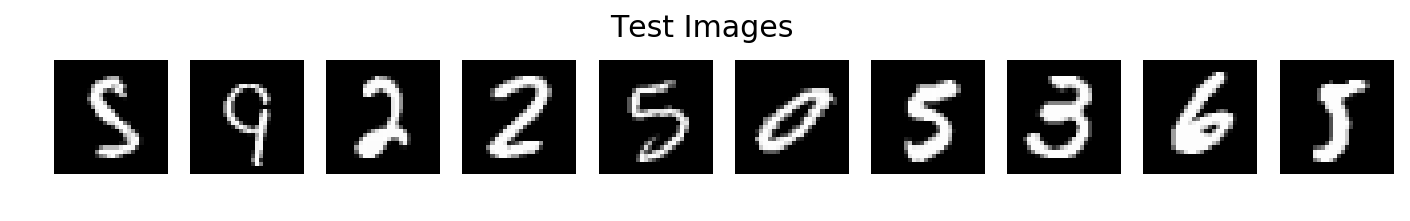

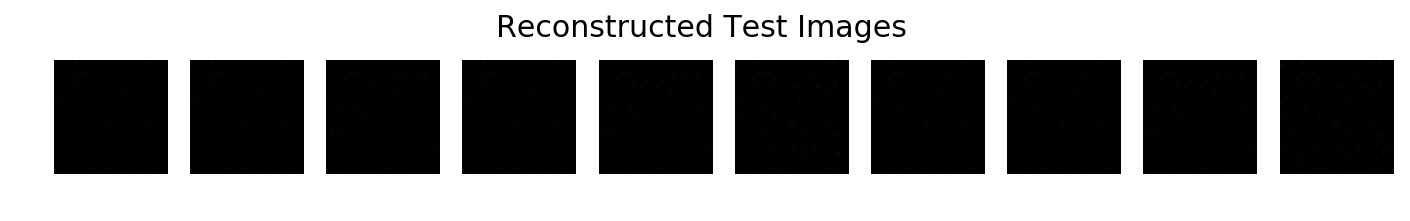

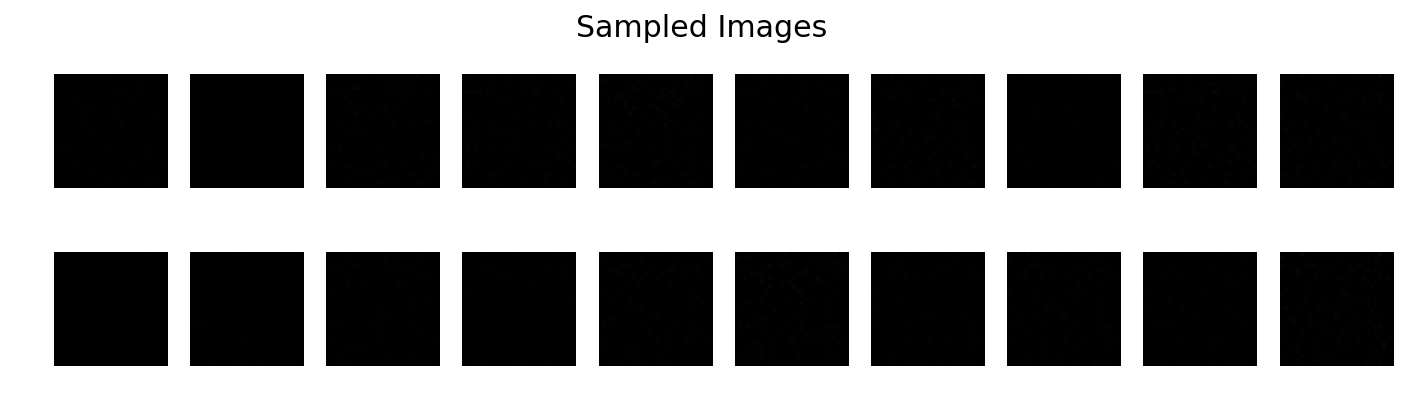

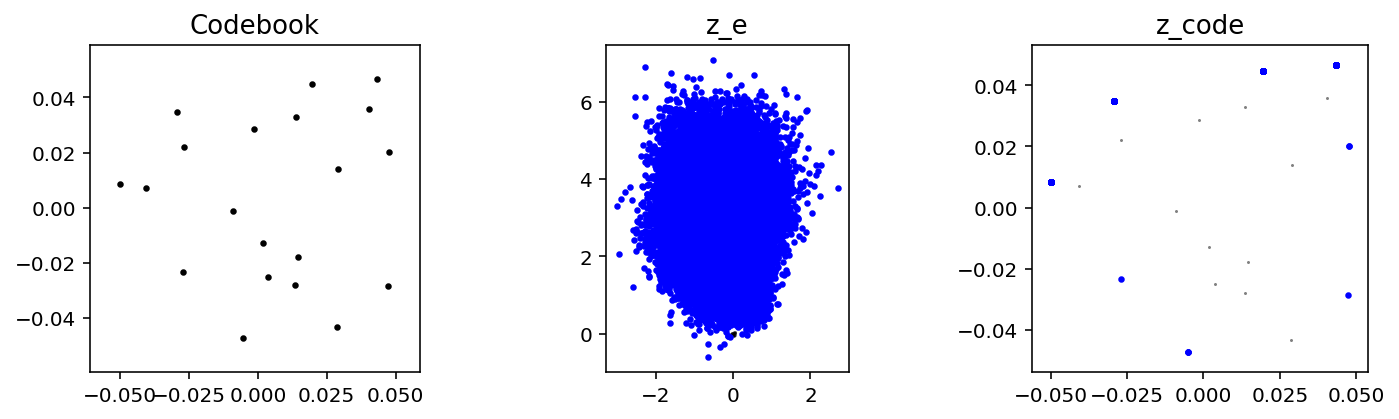

In [7]:
V.init_params()
vqvae_mnist_debug(**dpi)

Start training.
[0/100] total:[0.124] recon:[0.103] embedding:[0.022]


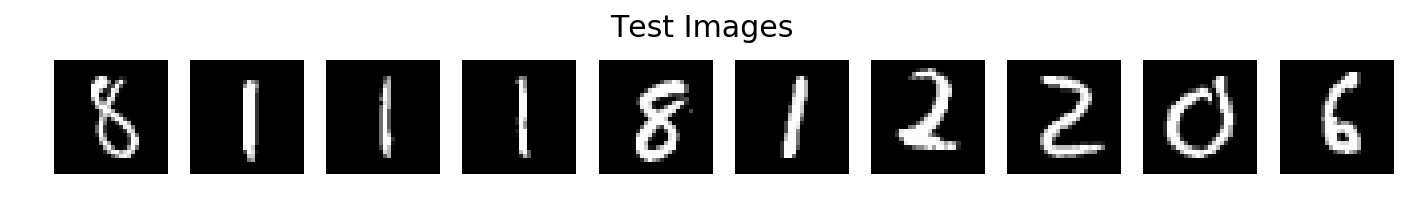

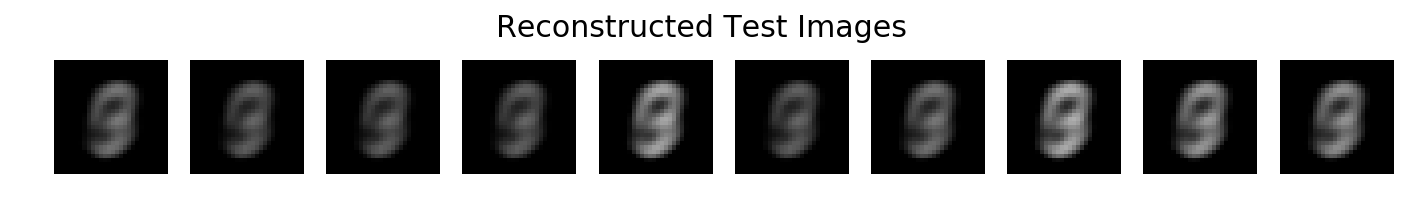

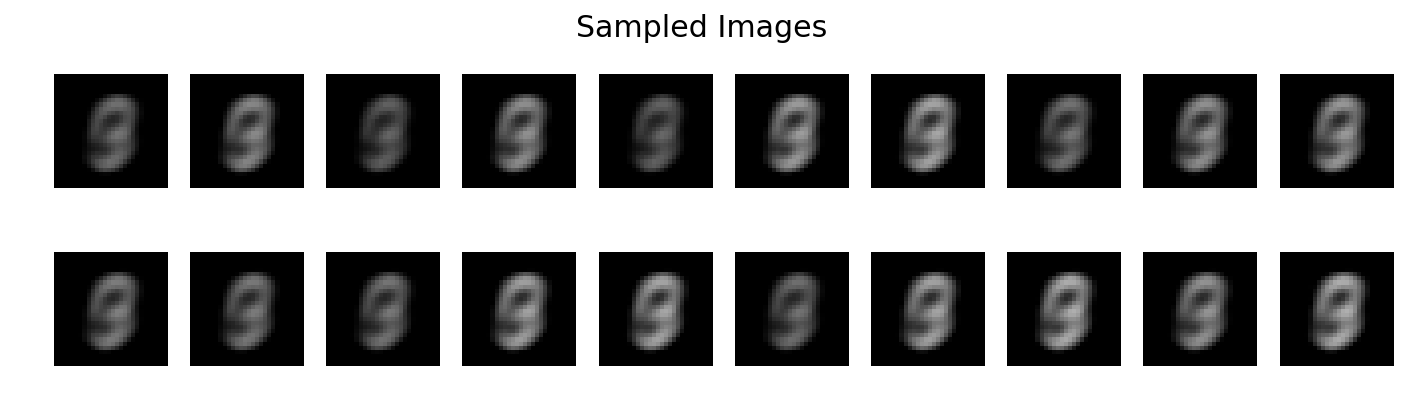

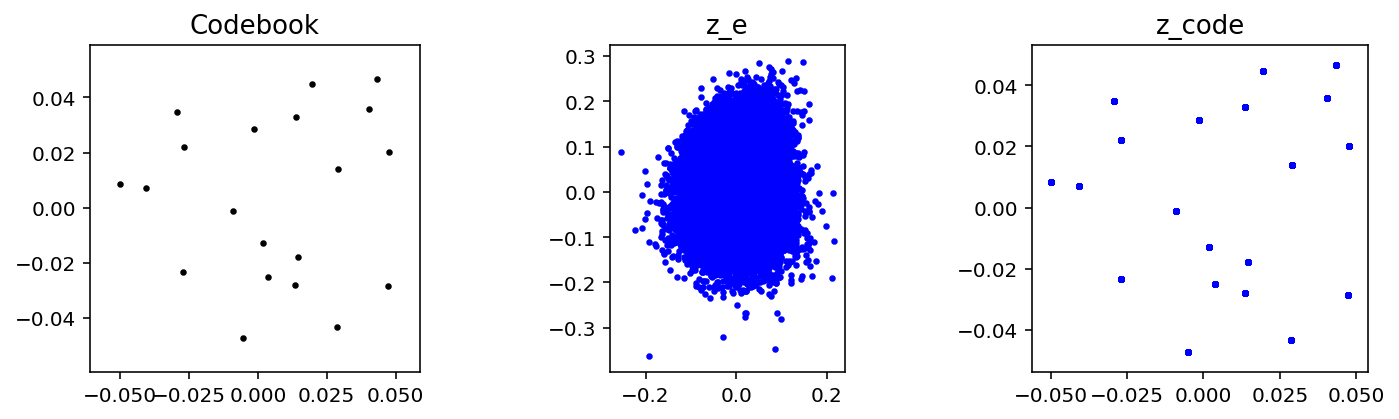

[1/100] total:[0.095] recon:[0.094] embedding:[0.001]
[2/100] total:[0.089] recon:[0.089] embedding:[0.000]
[3/100] total:[0.088] recon:[0.088] embedding:[0.000]
[4/100] total:[0.087] recon:[0.086] embedding:[0.000]
[5/100] total:[0.085] recon:[0.084] embedding:[0.000]
[6/100] total:[0.083] recon:[0.083] embedding:[0.000]
[7/100] total:[0.082] recon:[0.082] embedding:[0.000]
[8/100] total:[0.080] recon:[0.080] embedding:[0.000]
[9/100] total:[0.079] recon:[0.079] embedding:[0.000]
[10/100] total:[0.079] recon:[0.078] embedding:[0.000]


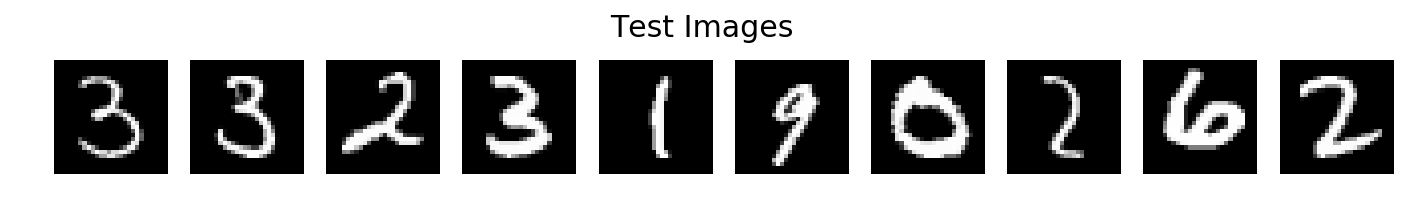

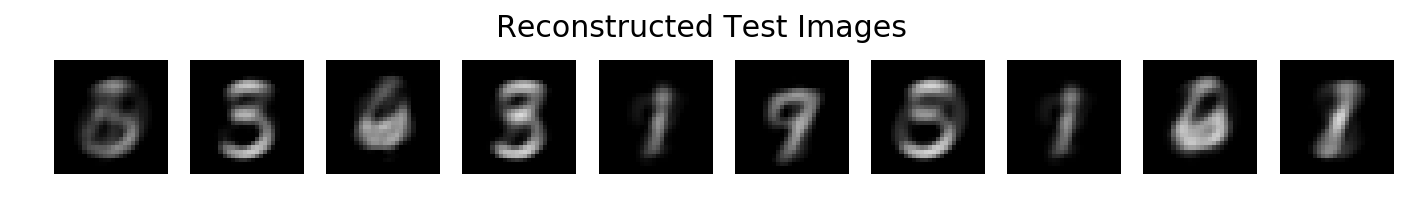

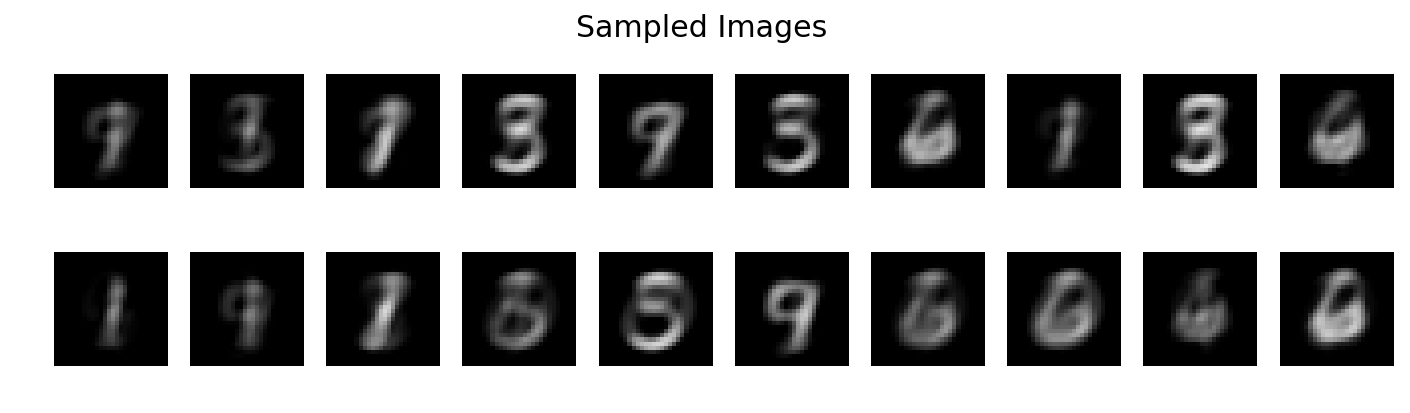

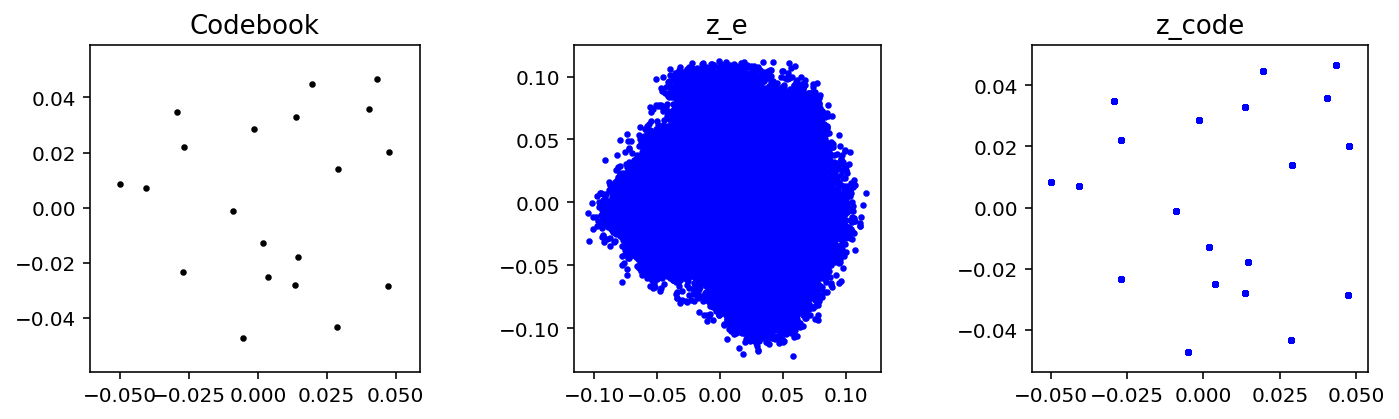

[11/100] total:[0.078] recon:[0.078] embedding:[0.000]
[12/100] total:[0.078] recon:[0.077] embedding:[0.000]
[13/100] total:[0.077] recon:[0.077] embedding:[0.000]
[14/100] total:[0.077] recon:[0.077] embedding:[0.000]
[15/100] total:[0.077] recon:[0.077] embedding:[0.000]
[16/100] total:[0.077] recon:[0.076] embedding:[0.000]
[17/100] total:[0.076] recon:[0.076] embedding:[0.000]
[18/100] total:[0.076] recon:[0.076] embedding:[0.000]
[19/100] total:[0.076] recon:[0.075] embedding:[0.000]
[20/100] total:[0.075] recon:[0.075] embedding:[0.000]


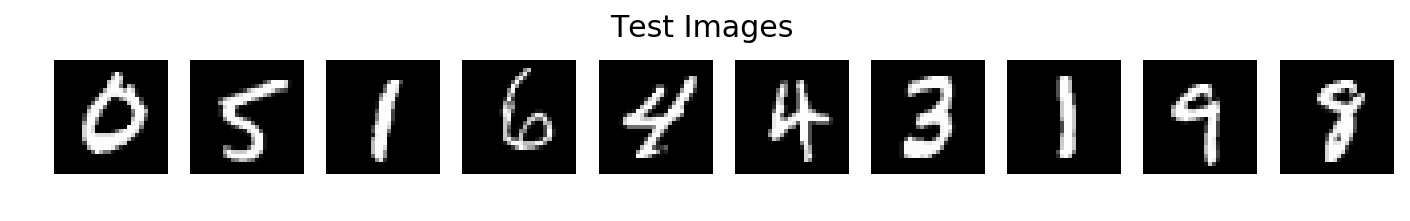

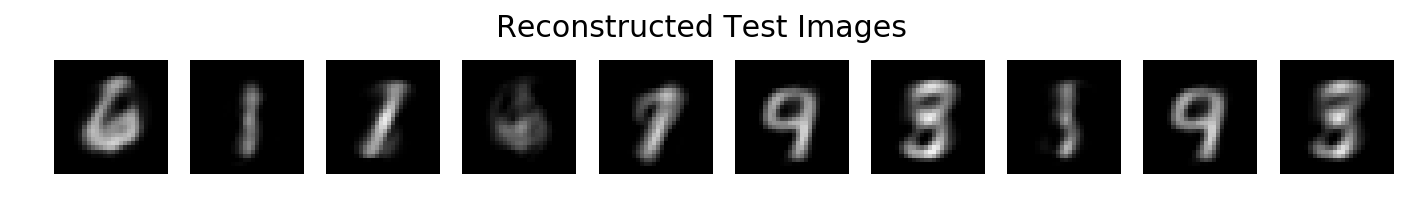

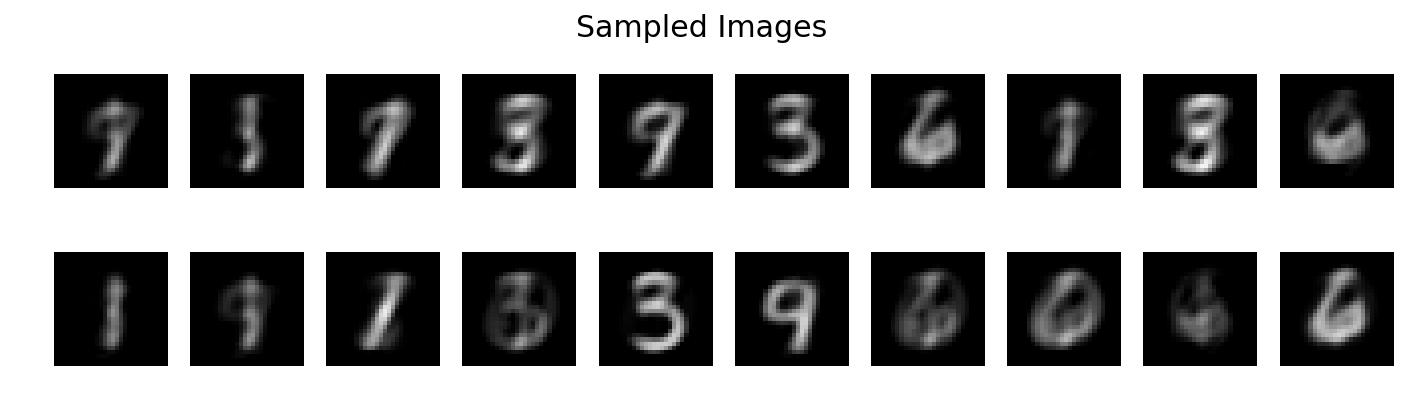

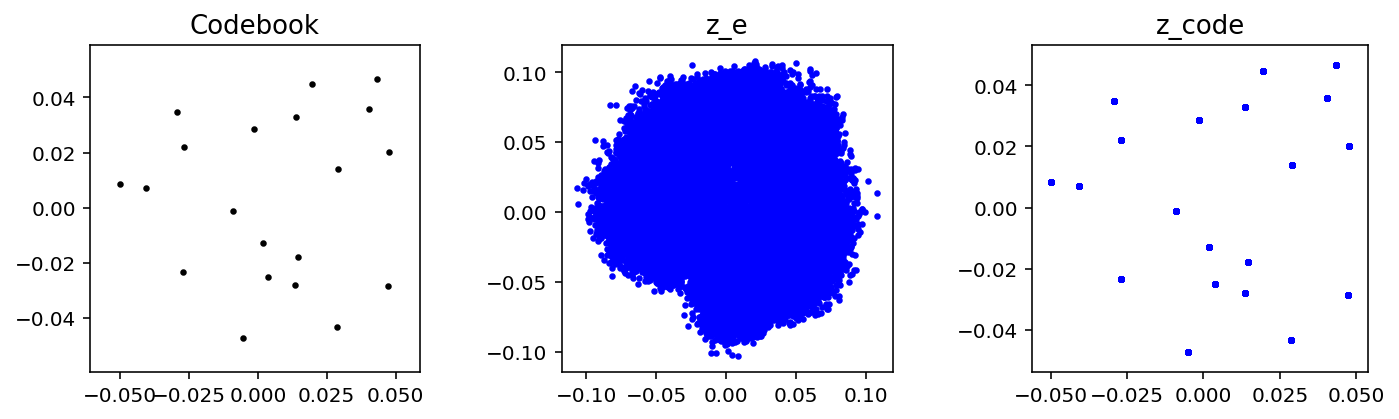

[21/100] total:[0.075] recon:[0.075] embedding:[0.000]
[22/100] total:[0.075] recon:[0.075] embedding:[0.000]
[23/100] total:[0.074] recon:[0.074] embedding:[0.000]
[24/100] total:[0.074] recon:[0.074] embedding:[0.000]
[25/100] total:[0.074] recon:[0.073] embedding:[0.000]
[26/100] total:[0.073] recon:[0.073] embedding:[0.000]
[27/100] total:[0.073] recon:[0.073] embedding:[0.000]
[28/100] total:[0.073] recon:[0.072] embedding:[0.000]
[29/100] total:[0.072] recon:[0.072] embedding:[0.000]
[30/100] total:[0.072] recon:[0.072] embedding:[0.000]


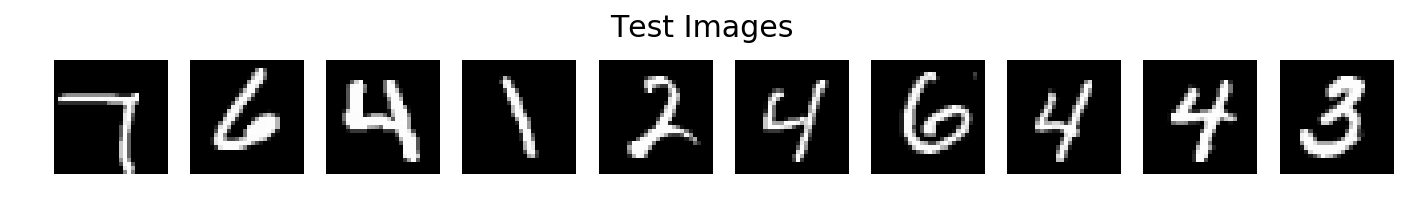

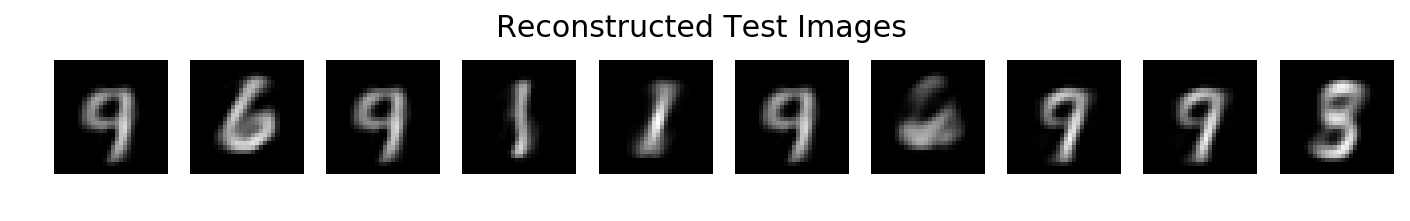

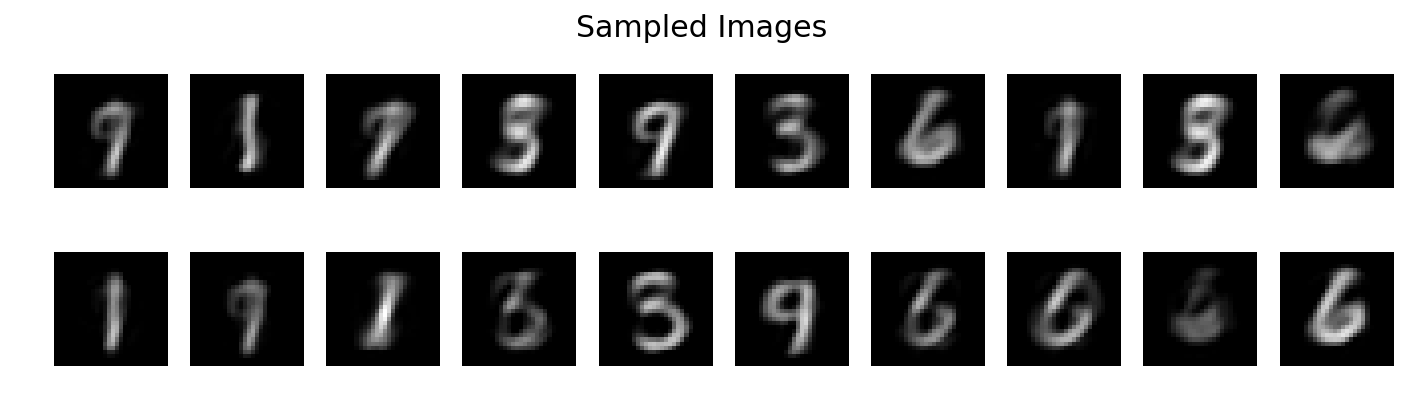

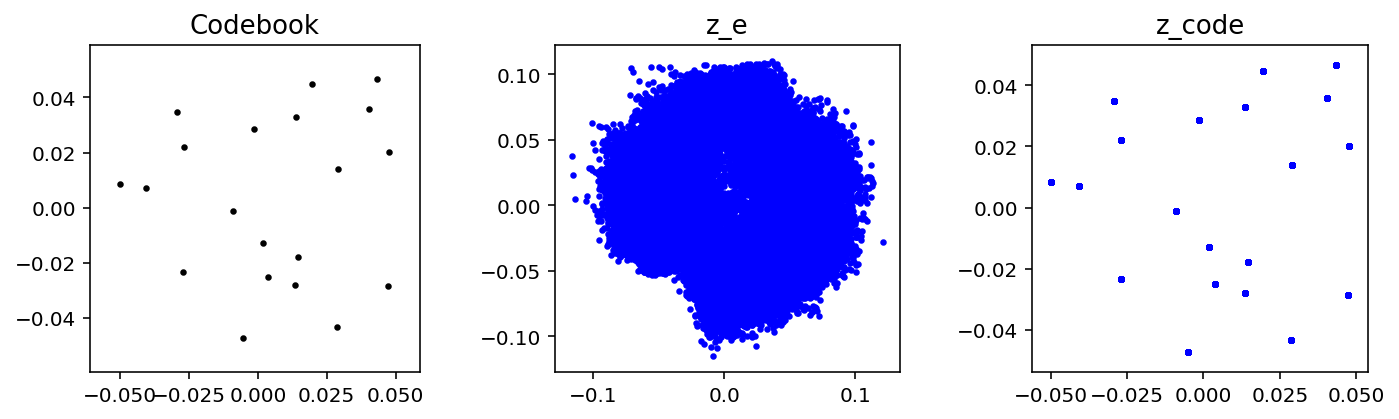

[31/100] total:[0.072] recon:[0.072] embedding:[0.000]
[32/100] total:[0.072] recon:[0.071] embedding:[0.000]
[33/100] total:[0.071] recon:[0.071] embedding:[0.000]
[34/100] total:[0.071] recon:[0.071] embedding:[0.000]
[35/100] total:[0.071] recon:[0.071] embedding:[0.000]
[36/100] total:[0.071] recon:[0.071] embedding:[0.000]
[37/100] total:[0.071] recon:[0.071] embedding:[0.000]
[38/100] total:[0.071] recon:[0.070] embedding:[0.000]
[39/100] total:[0.070] recon:[0.070] embedding:[0.000]
[40/100] total:[0.070] recon:[0.070] embedding:[0.000]


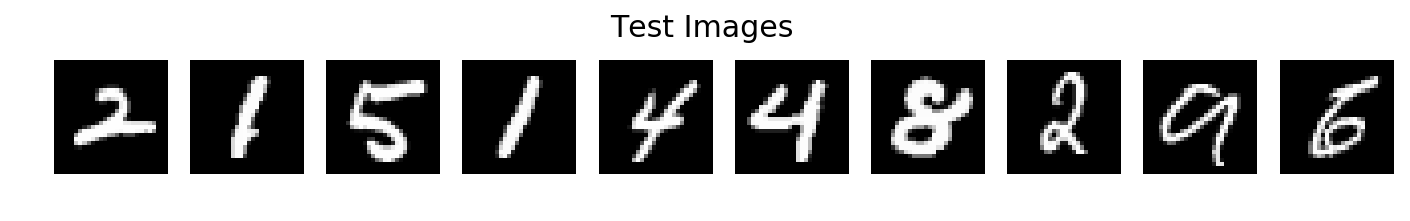

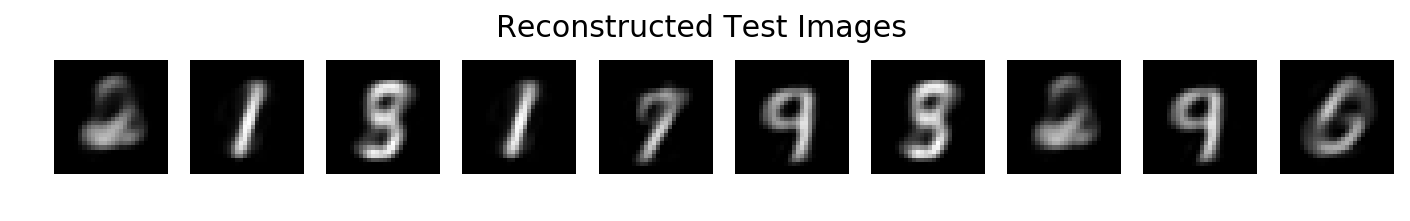

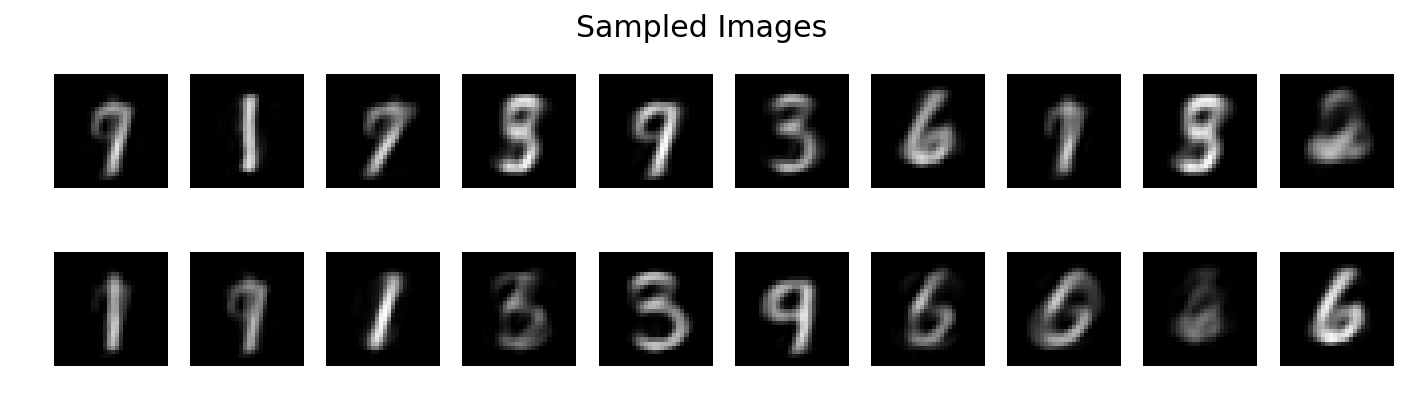

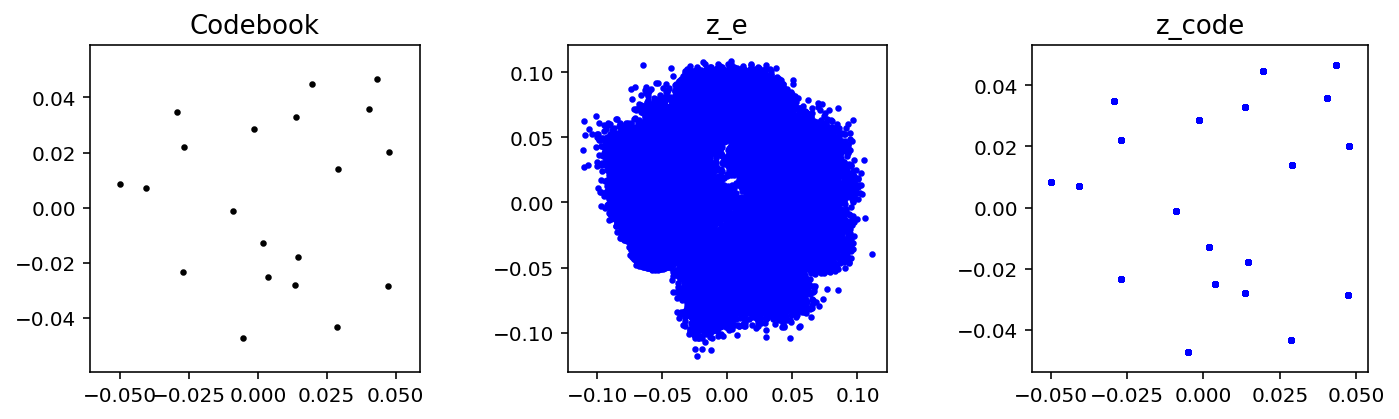

[41/100] total:[0.070] recon:[0.070] embedding:[0.000]
[42/100] total:[0.070] recon:[0.070] embedding:[0.000]
[43/100] total:[0.070] recon:[0.070] embedding:[0.000]
[44/100] total:[0.070] recon:[0.070] embedding:[0.000]
[45/100] total:[0.070] recon:[0.069] embedding:[0.000]
[46/100] total:[0.069] recon:[0.069] embedding:[0.000]
[47/100] total:[0.069] recon:[0.069] embedding:[0.000]
[48/100] total:[0.069] recon:[0.069] embedding:[0.000]
[49/100] total:[0.069] recon:[0.069] embedding:[0.000]
[50/100] total:[0.069] recon:[0.069] embedding:[0.000]


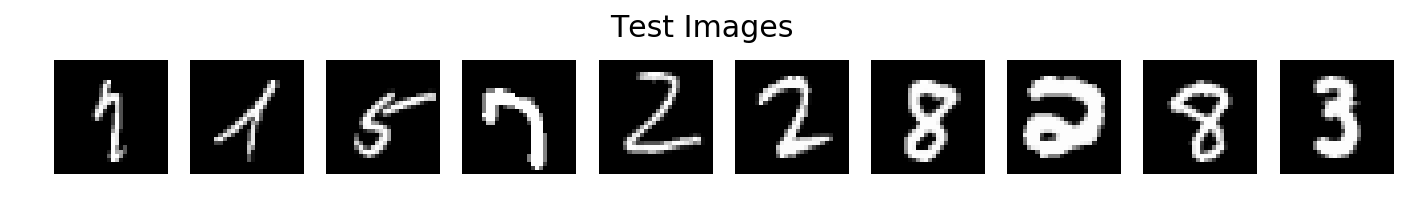

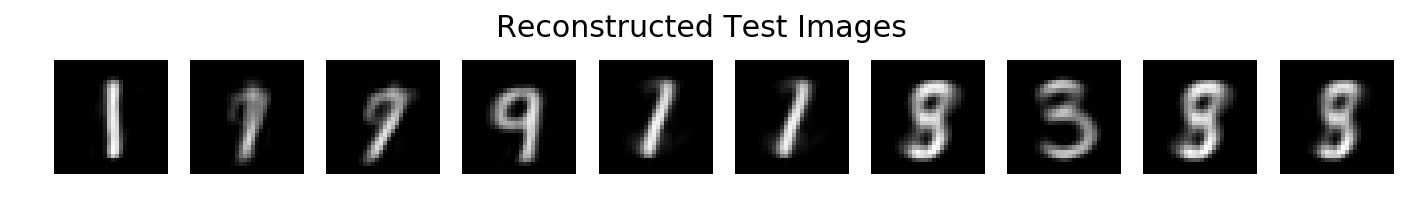

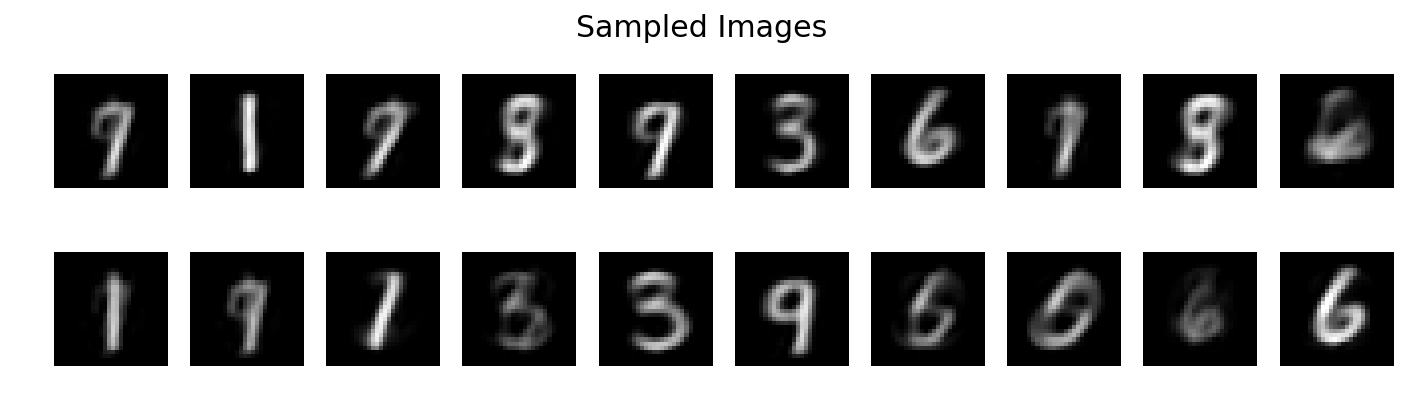

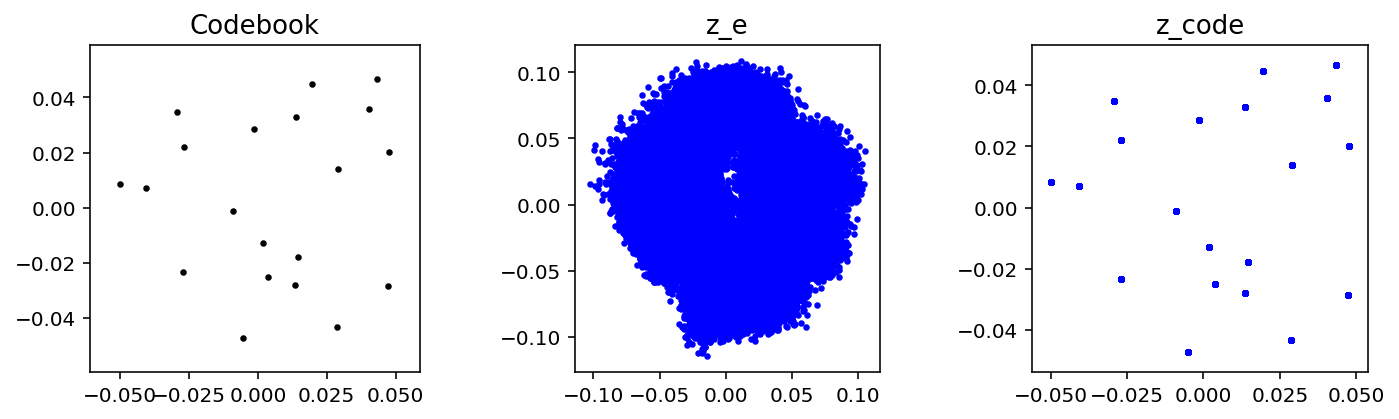

[51/100] total:[0.069] recon:[0.069] embedding:[0.000]
[52/100] total:[0.069] recon:[0.069] embedding:[0.000]
[53/100] total:[0.069] recon:[0.068] embedding:[0.000]
[54/100] total:[0.069] recon:[0.068] embedding:[0.000]
[55/100] total:[0.068] recon:[0.068] embedding:[0.000]
[56/100] total:[0.068] recon:[0.068] embedding:[0.000]
[57/100] total:[0.068] recon:[0.068] embedding:[0.000]
[58/100] total:[0.068] recon:[0.068] embedding:[0.000]
[59/100] total:[0.068] recon:[0.067] embedding:[0.000]
[60/100] total:[0.068] recon:[0.067] embedding:[0.000]


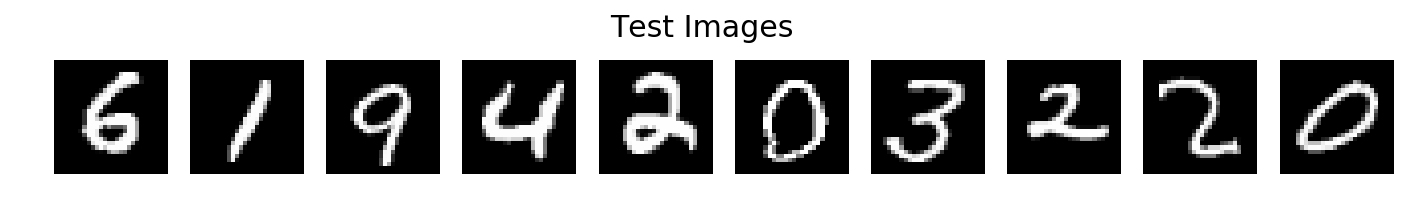

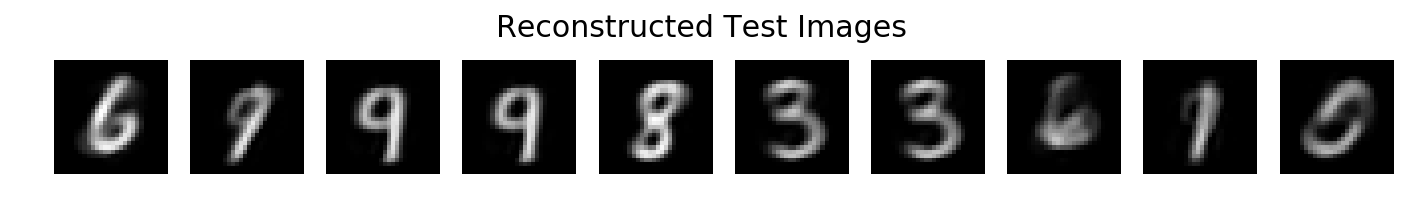

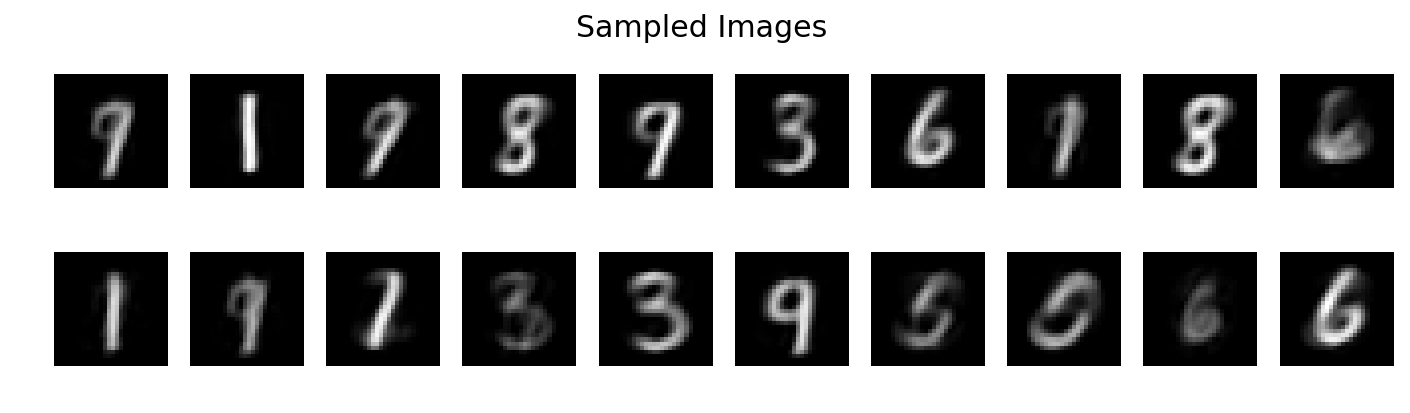

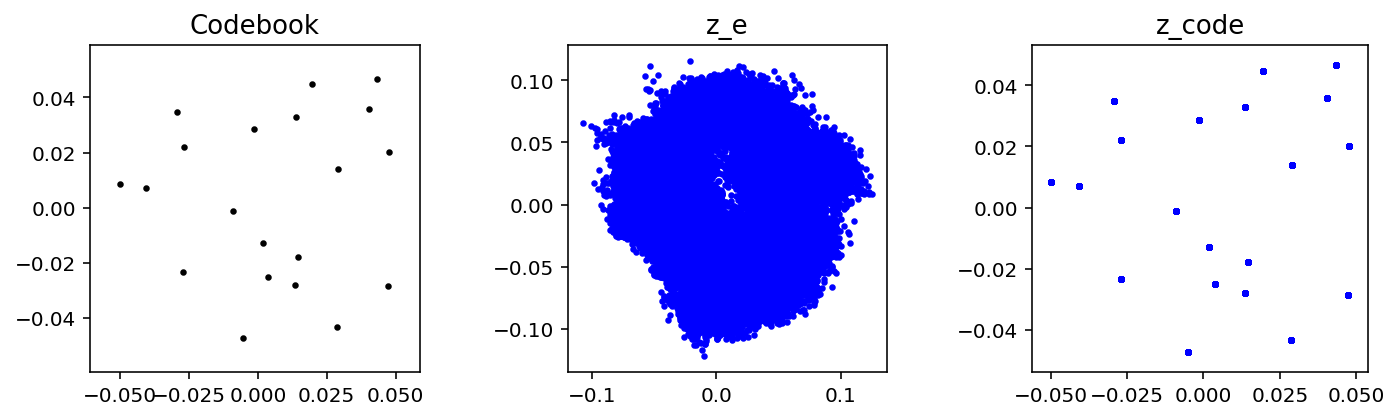

[61/100] total:[0.068] recon:[0.067] embedding:[0.000]
[62/100] total:[0.067] recon:[0.067] embedding:[0.000]
[63/100] total:[0.067] recon:[0.067] embedding:[0.000]
[64/100] total:[0.067] recon:[0.067] embedding:[0.000]
[65/100] total:[0.067] recon:[0.067] embedding:[0.000]
[66/100] total:[0.067] recon:[0.067] embedding:[0.000]
[67/100] total:[0.067] recon:[0.067] embedding:[0.000]
[68/100] total:[0.067] recon:[0.066] embedding:[0.000]
[69/100] total:[0.067] recon:[0.067] embedding:[0.000]
[70/100] total:[0.067] recon:[0.067] embedding:[0.000]


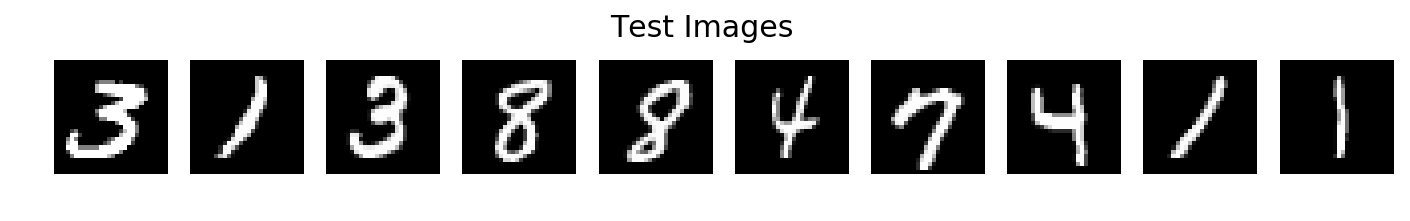

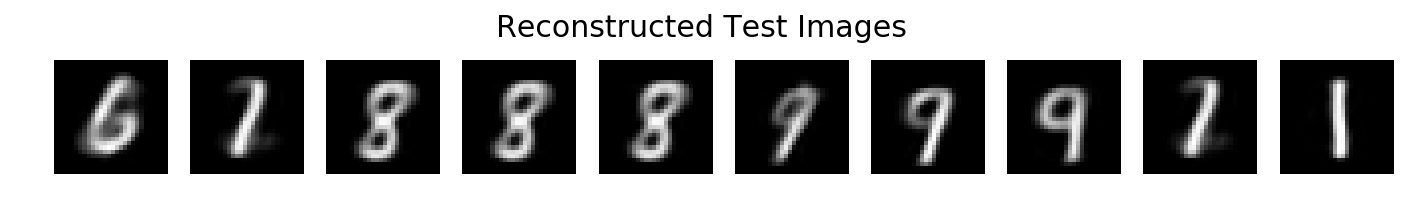

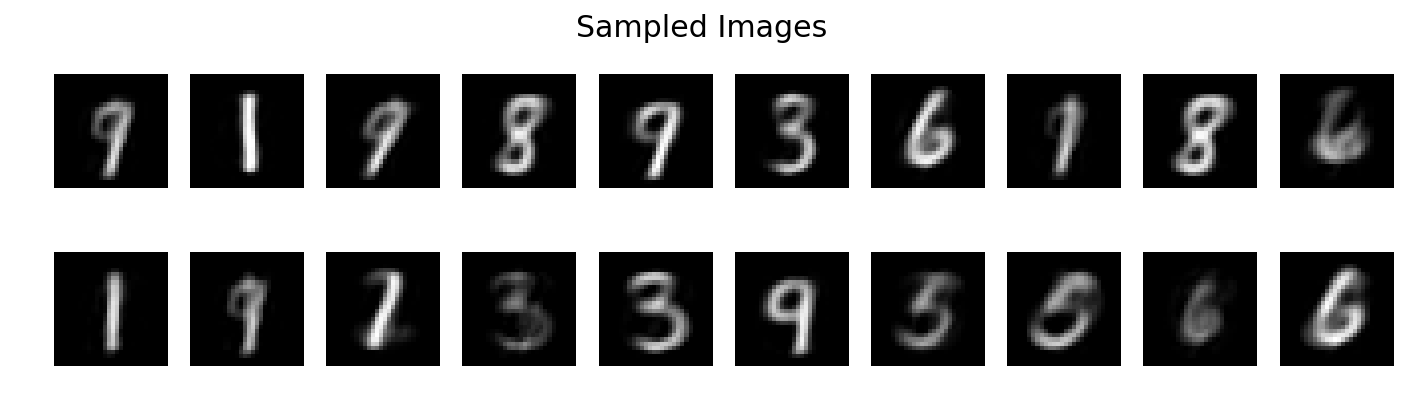

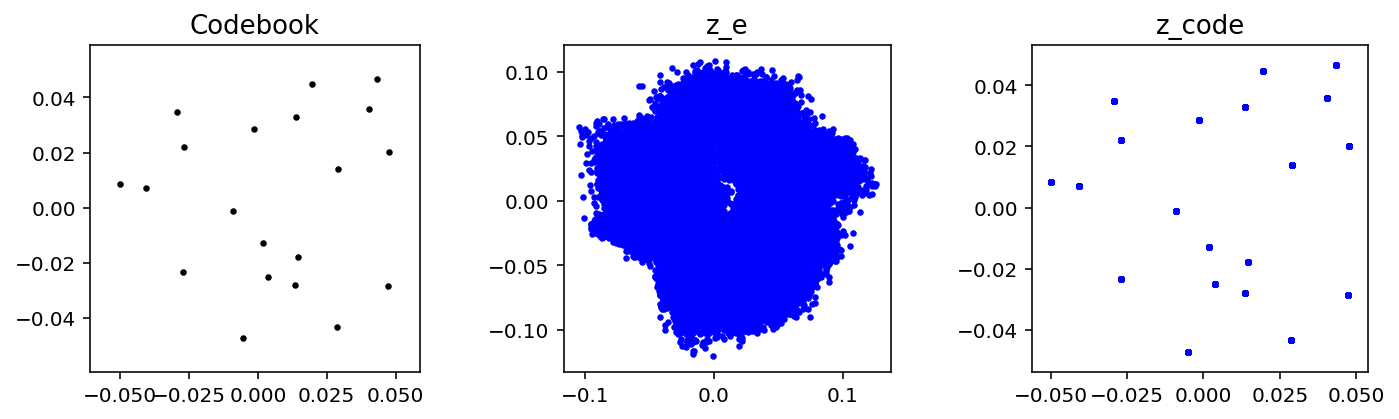

[71/100] total:[0.067] recon:[0.067] embedding:[0.000]
[72/100] total:[0.067] recon:[0.066] embedding:[0.000]
[73/100] total:[0.066] recon:[0.066] embedding:[0.000]
[74/100] total:[0.067] recon:[0.066] embedding:[0.000]
[75/100] total:[0.066] recon:[0.066] embedding:[0.000]
[76/100] total:[0.066] recon:[0.066] embedding:[0.000]
[77/100] total:[0.066] recon:[0.066] embedding:[0.000]
[78/100] total:[0.066] recon:[0.066] embedding:[0.000]
[79/100] total:[0.066] recon:[0.066] embedding:[0.000]
[80/100] total:[0.066] recon:[0.066] embedding:[0.000]


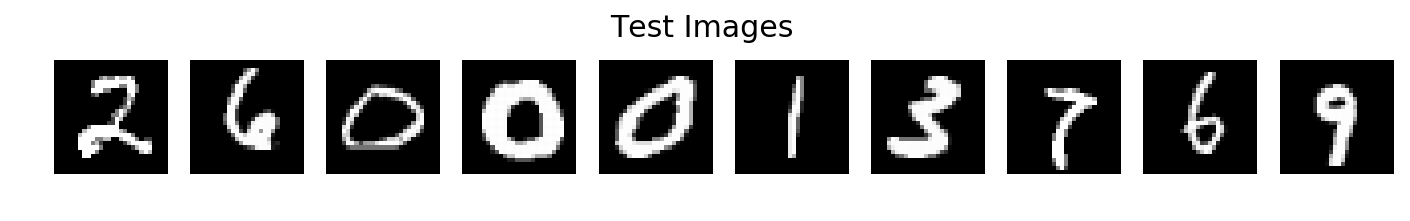

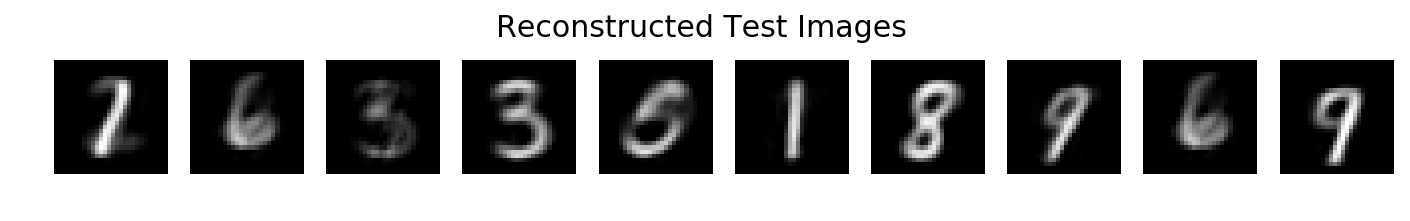

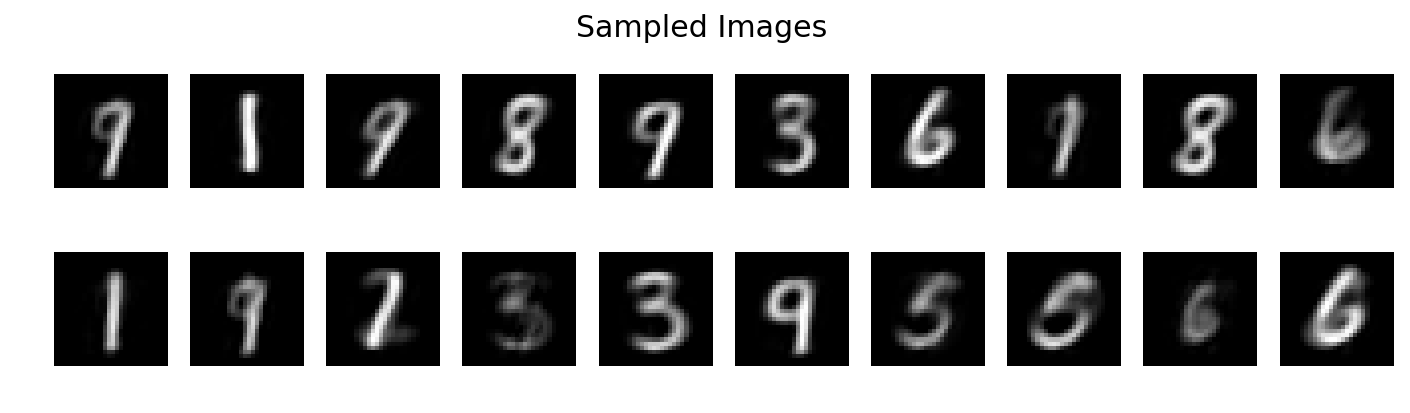

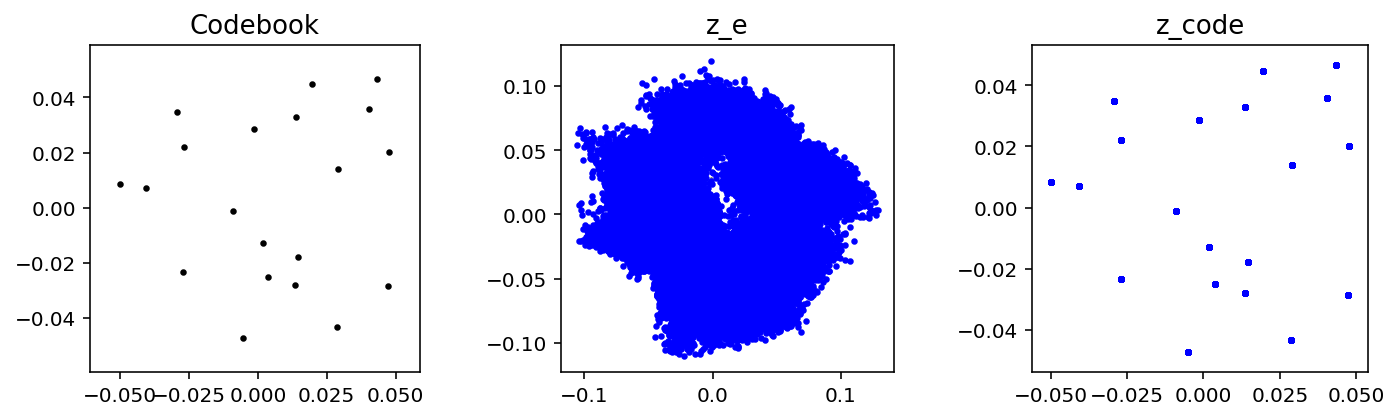

[81/100] total:[0.066] recon:[0.065] embedding:[0.000]
[82/100] total:[0.066] recon:[0.065] embedding:[0.000]
[83/100] total:[0.066] recon:[0.066] embedding:[0.000]
[84/100] total:[0.066] recon:[0.066] embedding:[0.000]
[85/100] total:[0.066] recon:[0.066] embedding:[0.000]
[86/100] total:[0.066] recon:[0.066] embedding:[0.000]
[87/100] total:[0.066] recon:[0.066] embedding:[0.000]
[88/100] total:[0.066] recon:[0.065] embedding:[0.000]
[89/100] total:[0.066] recon:[0.065] embedding:[0.000]
[90/100] total:[0.066] recon:[0.065] embedding:[0.000]


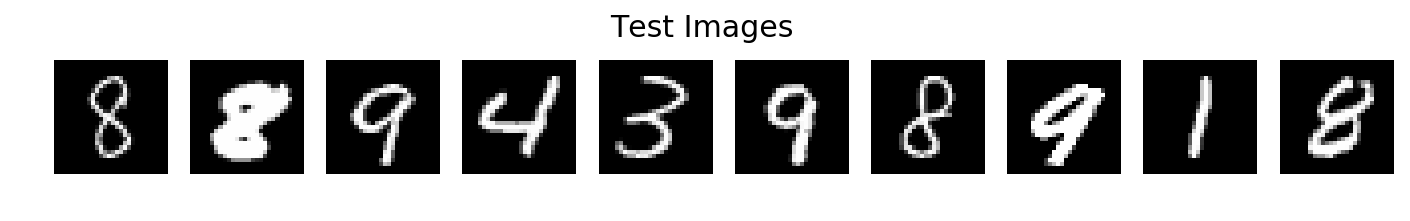

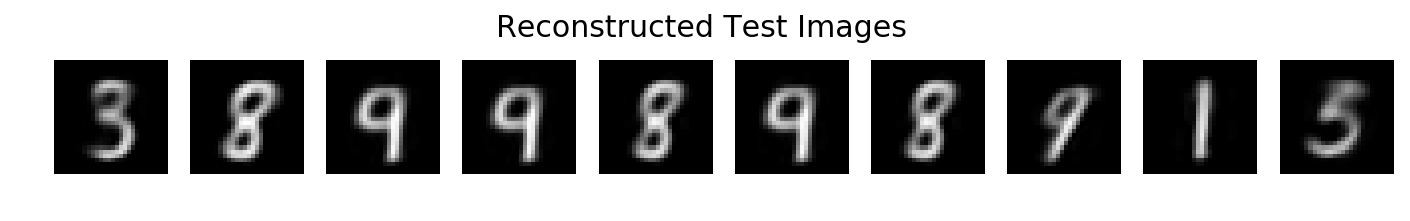

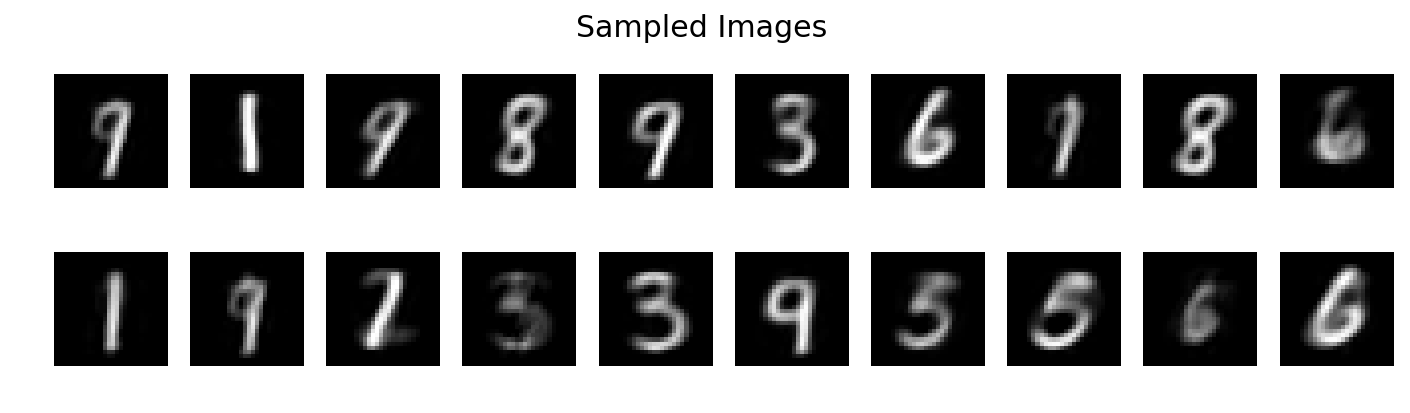

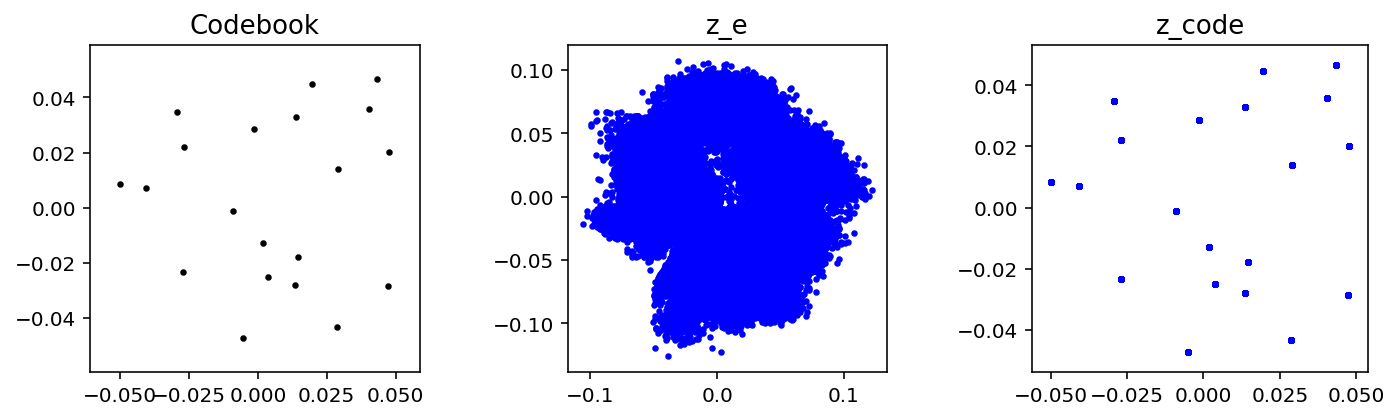

[91/100] total:[0.066] recon:[0.065] embedding:[0.000]
[92/100] total:[0.066] recon:[0.065] embedding:[0.000]
[93/100] total:[0.066] recon:[0.065] embedding:[0.000]
[94/100] total:[0.065] recon:[0.065] embedding:[0.000]
[95/100] total:[0.066] recon:[0.065] embedding:[0.000]
[96/100] total:[0.066] recon:[0.066] embedding:[0.000]
[97/100] total:[0.066] recon:[0.066] embedding:[0.000]
[98/100] total:[0.065] recon:[0.065] embedding:[0.000]
[99/100] total:[0.066] recon:[0.065] embedding:[0.000]


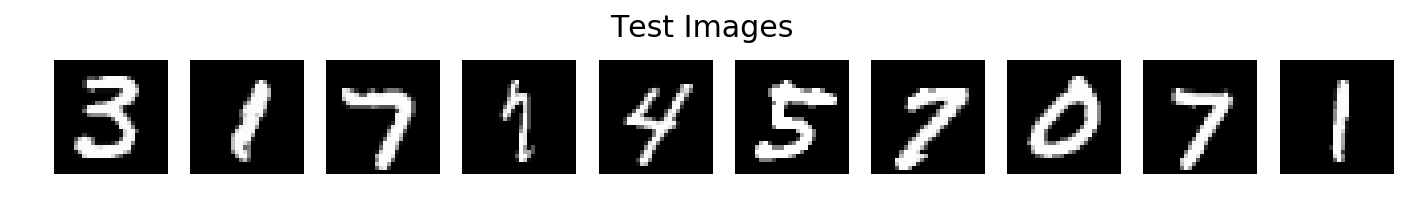

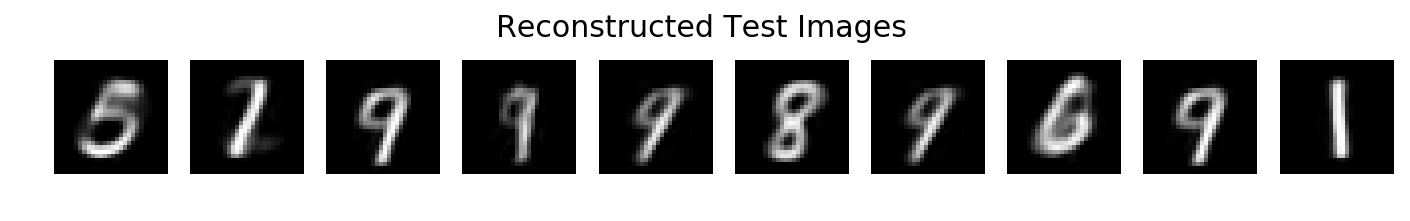

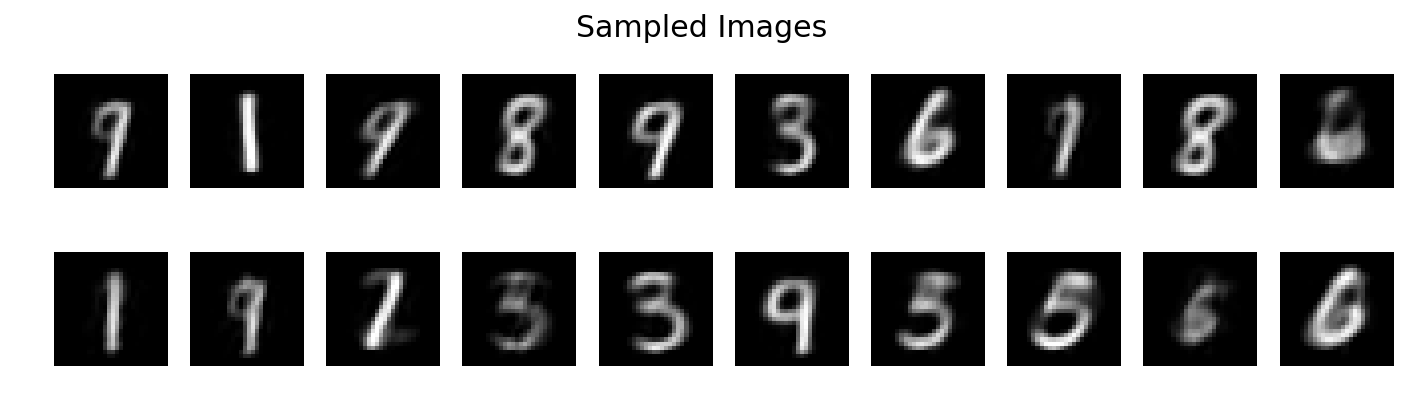

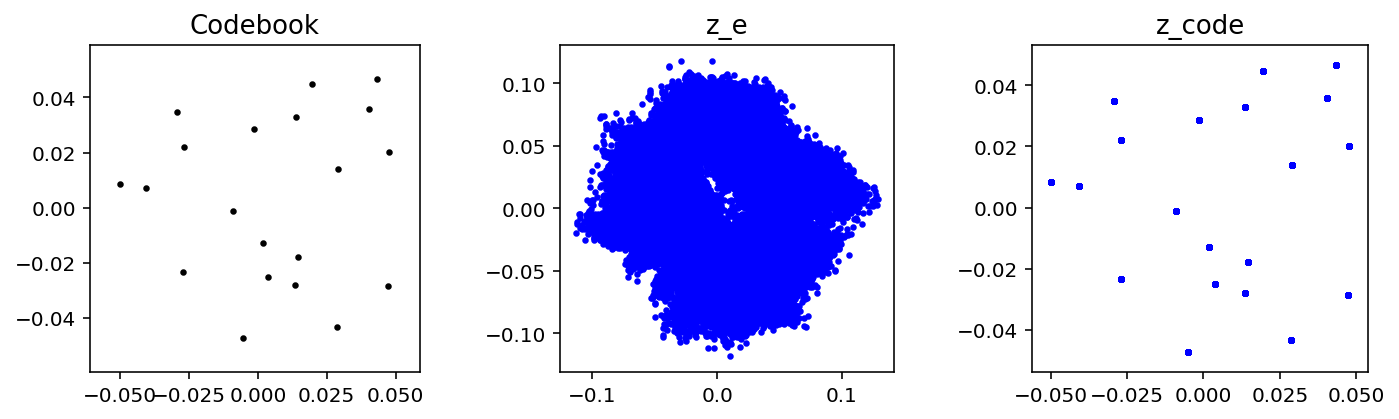

Done.


In [8]:
print ("Start training.")
V.init_params()
for epoch in range(n_epoch):
    V.train()
    zero_to_one = float(epoch/(n_epoch-1))
    loss_recon_sum,loss_embedding_sum,loss_total_sum,n_batch_sum = 0.0,0.0,0.0,0
    rand_idxs = np.random.permutation(n_train)
    for it in range(n_it):
        batch_idx     = rand_idxs[it*batch_size:(it+1)*batch_size]
        x_batch_torch = x_train_torch[batch_idx,:].to(V.device)
        n_batch       = x_batch_torch.shape[0]
        # Update
        total_loss_out,loss_info = V.loss_total(
            x               = x_batch_torch.to(V.device),
            LOSS_TYPE       = 'L1+L2',
            recon_loss_gain = 1.0,
            BYPASS          = True)
        optm.zero_grad(); total_loss_out.backward(); optm.step()
        # Errors
        loss_total_sum      = loss_total_sum + n_batch*loss_info['loss_total_out']
        loss_recon_sum      = loss_recon_sum + n_batch*loss_info['loss_recon_out']
        loss_embedding_sum  = loss_embedding_sum + n_batch*loss_info['loss_embedding_out']
        n_batch_sum    = n_batch_sum + n_batch
    loss_total_avg = loss_total_sum / n_batch_sum
    loss_recon_avg = loss_recon_sum / n_batch_sum
    loss_embedding_avg    = loss_embedding_sum / n_batch_sum
    
    # Print
    print ("[%d/%d] total:[%.3f] recon:[%.3f] embedding:[%.3f]"%
           (epoch,n_epoch,loss_total_avg,loss_recon_avg,loss_embedding_avg))
    
    # Plot test images
    if ((epoch%plot_every) == 0) or (epoch==(n_epoch-1)):
        vqvae_mnist_debug(**dpi)
print ("Done.")